# Image Preprocessing

In [1]:
import cv2
import glob
import fingerprint_enhancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## Oriented Gabor Filter Bank

In [2]:
IMAGE_PATH = '../dataset/'

def image_enhancement(img_path: str):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)						# read input image
    out = fingerprint_enhancer.enhance_fingerprint(img)		# enhance the fingerprint image

    plt.figure(figsize=(10, 5)) 

    plt.subplot(1, 2, 1)  # Create a 1x2 grid, and use the first subplot
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(out, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.title('Processed Image')  # Add a title
    plt.axis('off')  # Turn off axis labels

    plt.show()  # Display the image

--------------------Begin Image 105--------------------


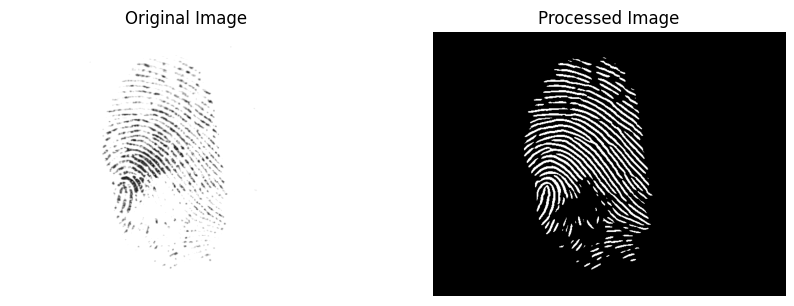

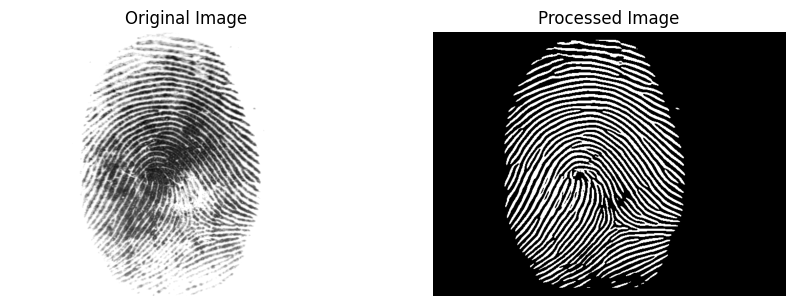

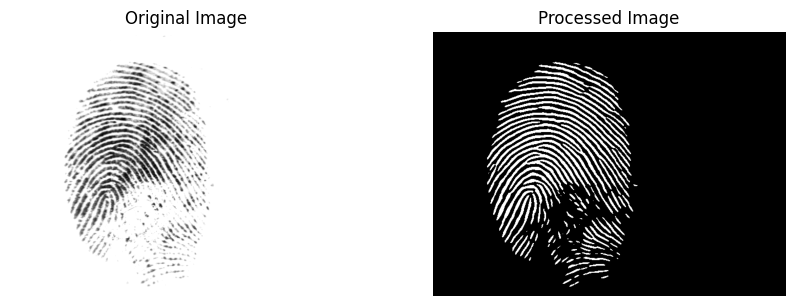

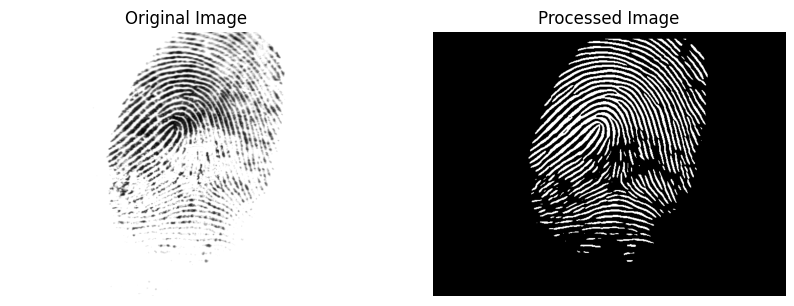

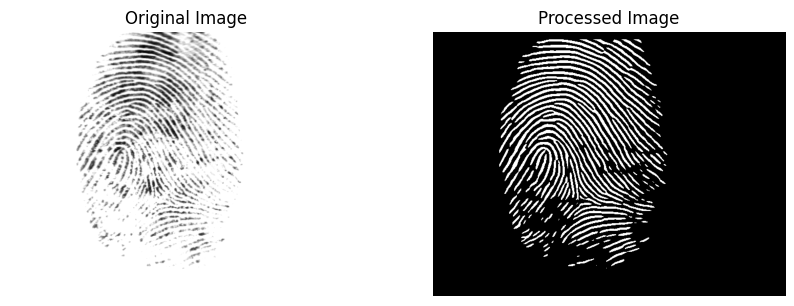

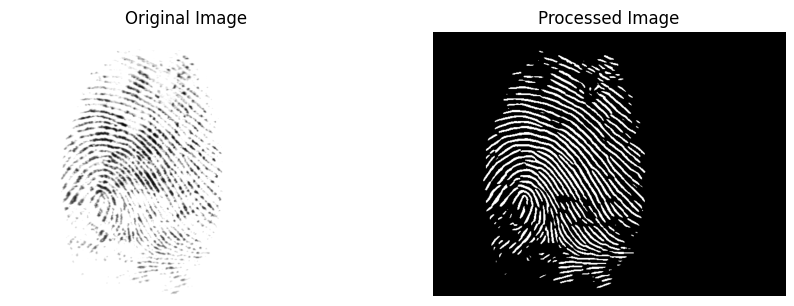

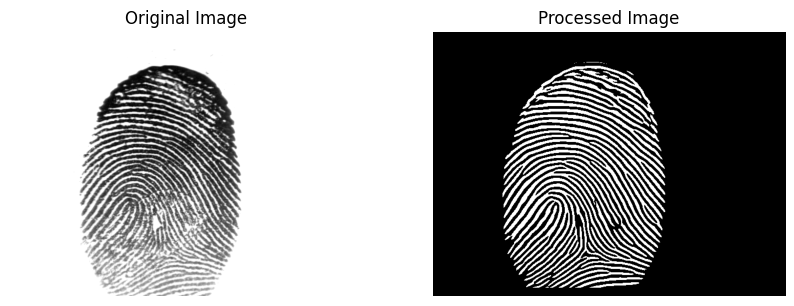

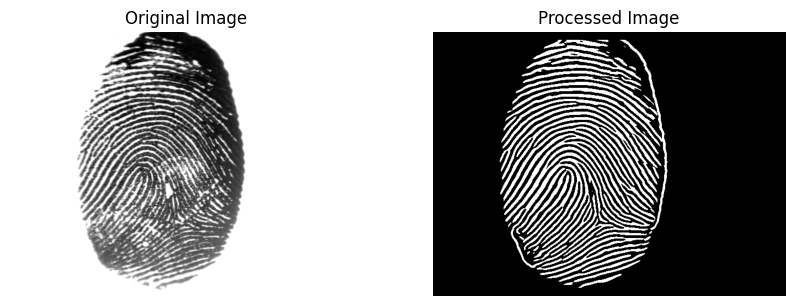

--------------------End Image 105--------------------


In [54]:
while True:
    image_index = int(input())
    if image_index == -1:
        break
    else:
        print('-'*20 + f"Begin Image 10{image_index}" + '-'*20)
        for i in range(1,9):
            image_enhancement('10'+str(image_index)+'_'+str(i))
        print('-'*20 + f"End Image 10{image_index}" + '-'*20)

## Handle Rotated Images (Not solved yet)
- Rotated Images: 109_5.tif, 107_6.tif 
- Detect blob in the image
- Compute angle of rotated blob
- Rotate the image to correct skew

In [15]:
# Binaries the image using Otsu's method
original_image = cv2.imread('../dataset/107_6.tif', cv2.IMREAD_GRAYSCALE)
thresh = cv2.threshold(original_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

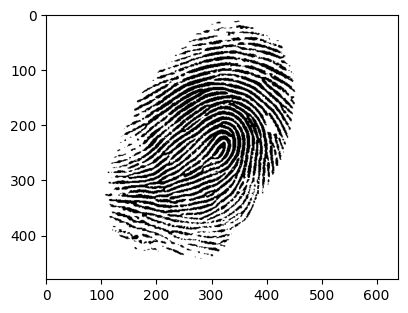

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(thresh, cmap='gray')

In [31]:
# Test the bounding box
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]

# Adjust the angle if it's less than -45
if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle
print(angle)

# Get the bounding box (center, size, and angle)
rect = cv2.minAreaRect(coords)

# Get the 4 vertices of the bounding box
box = cv2.boxPoints(rect)
box = np.int0(box)  # Convert to integer points

# Draw the bounding box on the image
image_with_box = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)  # Convert grayscale to color for visualization
cv2.polylines(image_with_box, [box], isClosed=True, color=(0, 255, 0), thickness=2)

# Display the image with the bounding box
cv2.imshow('Bounding Box', image_with_box)
cv2.waitKey(0)
cv2.destroyAllWindows()

-90.0


C:\Users\PC\AppData\Local\Temp\ipykernel_27532\2997222426.py:17: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)  # Convert to integer points


In [29]:
# Compute the angle of the rotated blob using bouding box and calculate the skew angle
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]

angle

90.0

In [22]:
# Apply an affine transformation to correct the skew

(h, w) = original_image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(original_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

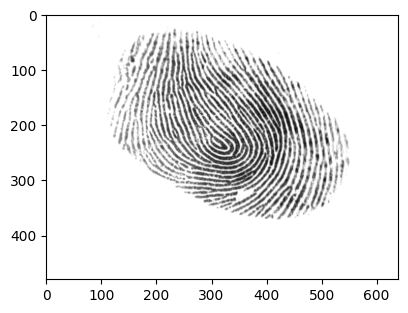

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rotated, cmap='gray')

plt.show()

<b>NOTE</b> Have big problem with large boundary box to real ROI of a fingerprint.
=> We must be focus on the actual fingerprint region
=> Find the contours then calculate bounding boxes.

In [52]:
# Load the image
image = cv2.imread('../dataset/101_2.tif', cv2.IMREAD_GRAYSCALE)

# Apply thresholding to binarize the image (invert the colors to get white fingerprint)
_, thresh = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)  # Inverted for dark fingerprint

# Optionally apply a Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(thresh, (5, 5), 0)

# Find contours
contours, _ = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the largest contour (which is assumed to be the fingerprint)
largest_contour = max(contours, key=cv2.contourArea)

# Compute the centroid (core) of the largest contour
M = cv2.moments(largest_contour)
cx = int(M['m10'] / M['m00'])  # X coordinate of the centroid
cy = int(M['m01'] / M['m00'])  # Y coordinate of the centroid

# Draw the core (centroid) on the image
image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color image
cv2.circle(image_bgr, (cx, cy), 5, (0, 0, 255), -1)  # Draw the core (red dot)

# Get the minimum area rectangle around the contour (to calculate skew angle)
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)  # Convert to integer points
angle = rect[-1]

# Adjust the angle to be in the correct orientation
if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle

# Draw the bounding box around the fingerprint
cv2.drawContours(image_bgr, [box], -1, (0, 255, 0), 2)  # Green bounding box

# Display the results
cv2.imshow('Fingerprint Core and Skew Angle', image_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print the calculated skew angle
print(f"Calculated skew angle: {angle} degrees")

C:\Users\PC\AppData\Local\Temp\ipykernel_27532\582167277.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)  # Convert to integer points


Calculated skew angle: -81.40408325195312 degrees


## Test with other dataset

- Family Fingerprint Dataset: Family 1 and 2: (child, father, mother)
    - Containing x sub folder FAMILYx, in each folder contain fingerprint of child, parent.
- SOCOFing: only 1
    - Contain fingeprint of 10 fingers of a person
- FVC2002: DB2_B
    - Include 8 impressions per finger


### FAMILY 1,2

--------------------Start Family 1 Children--------------------


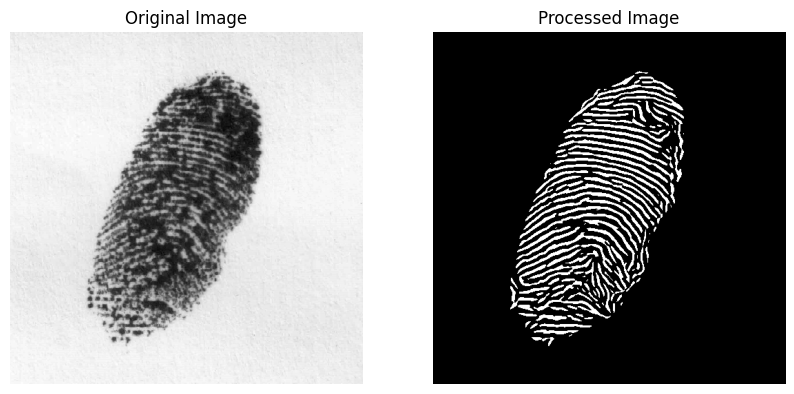

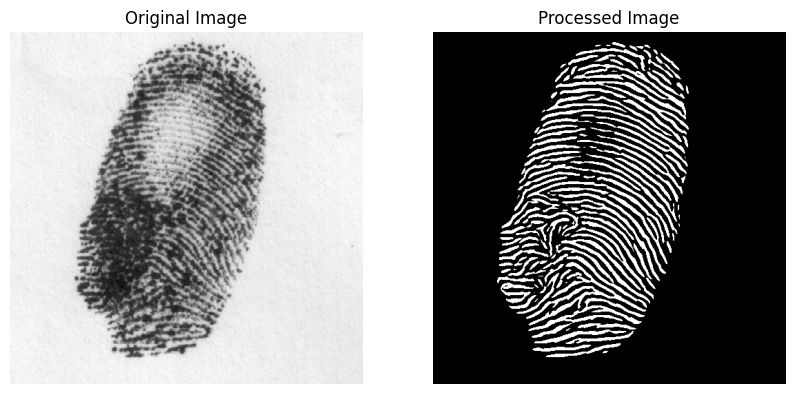

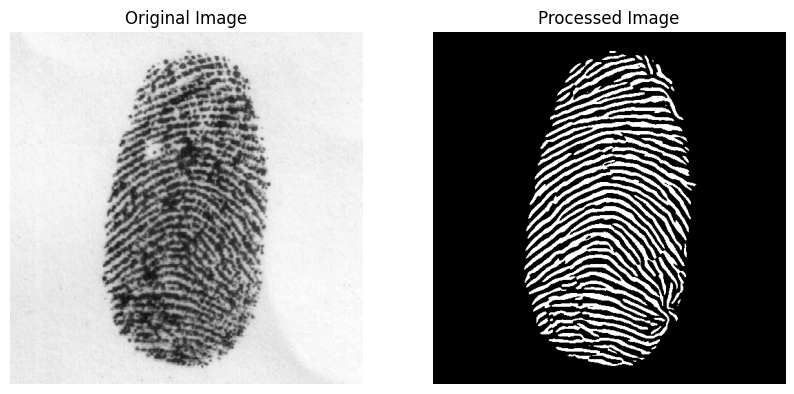

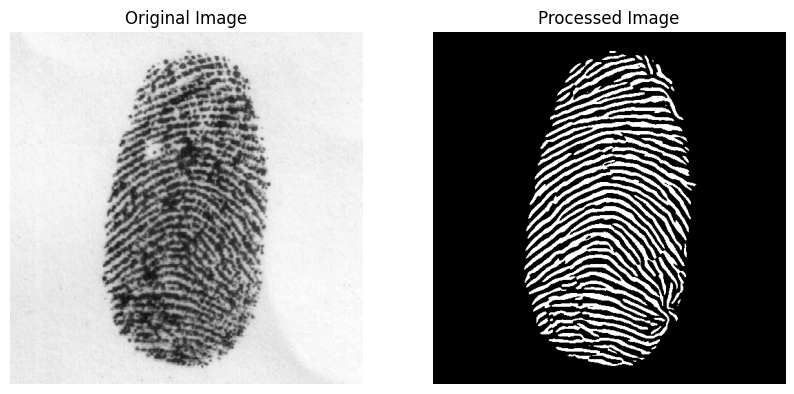

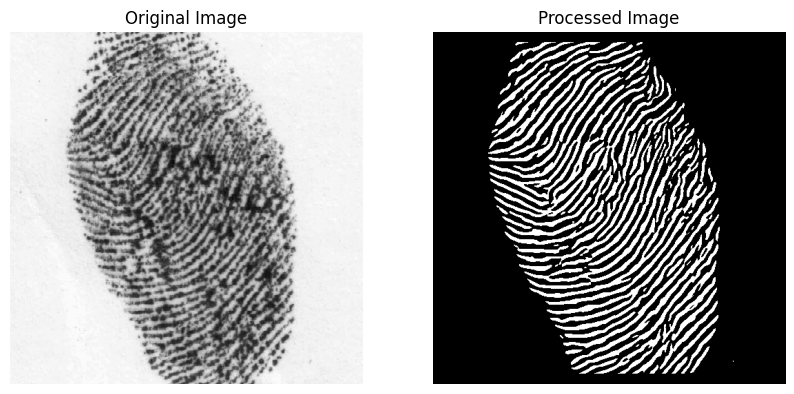

--------------------End Family 1 Children--------------------
--------------------Start Family 2 Children--------------------


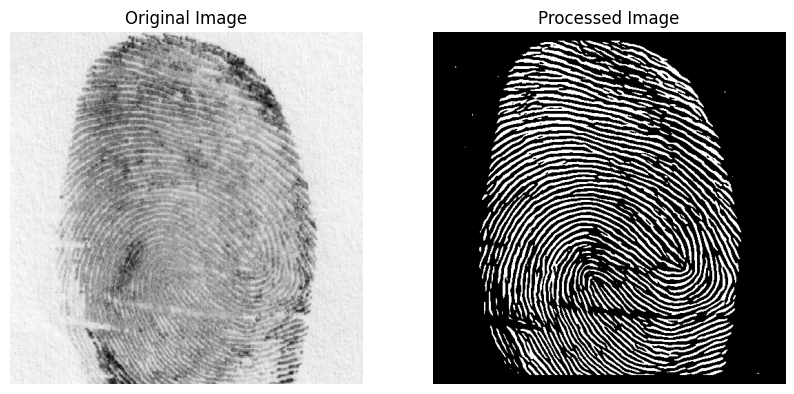

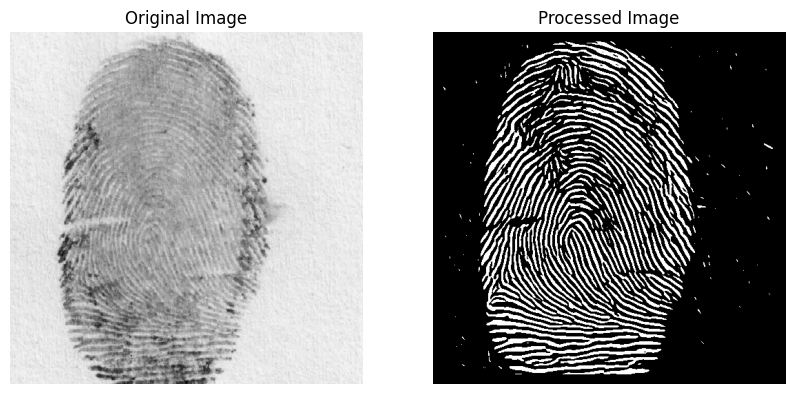

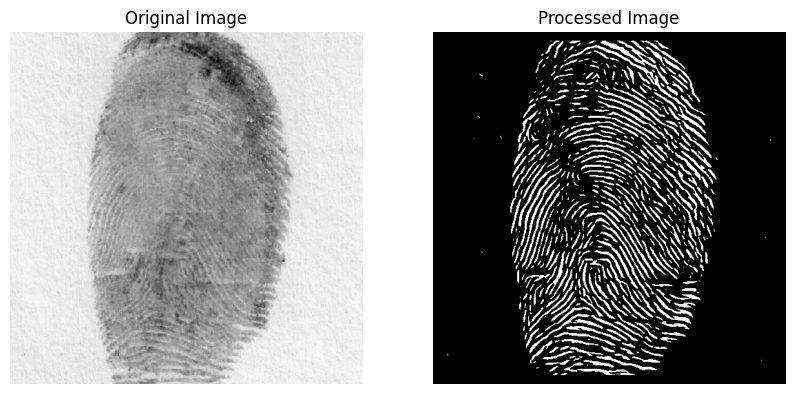

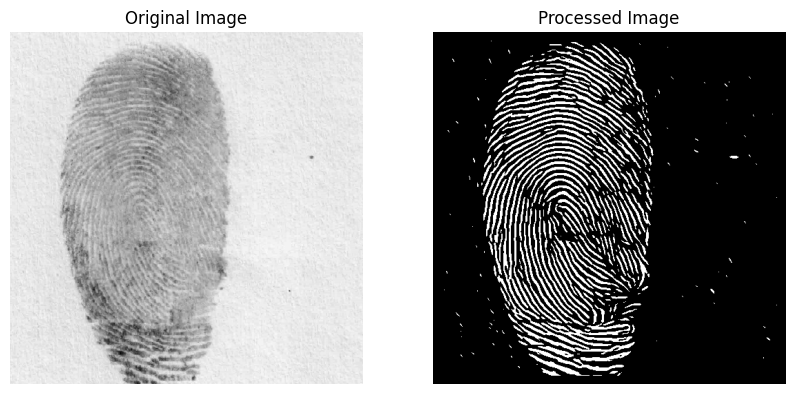

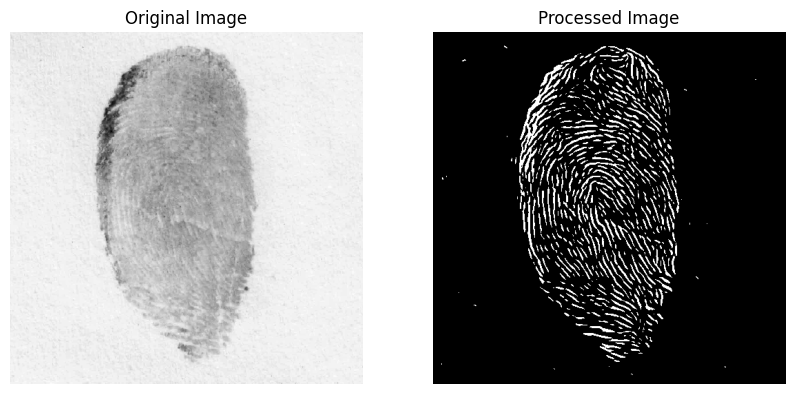

--------------------End Family 2 Children--------------------


In [7]:
FAMILY_1 = 'D:/Fingerprint Biometrics Authentication System/Dataset/FAMILY FINGERPRINT DATASET/FAMILY FINGERPRINT DATASET/FAMILY-1/'
FAMILY_2 = 'D:/Fingerprint Biometrics Authentication System/Dataset/FAMILY FINGERPRINT DATASET/FAMILY FINGERPRINT DATASET/FAMILY-2/'

# Children fingerprints
print('-'*20 + 'Start Family 1 Children' + '-'*20)
for i in range(1,6):
    image_name = FAMILY_1 + f'CHILD/FM001_C{i}.png'
    image_enhancement(image_name)
print('-'*20 + 'End Family 1 Children' + '-'*20)

print('-'*20 + 'Start Family 2 Children' + '-'*20)
for i in range(1,6):
    image_name = FAMILY_2 + f'CHILD/FM002_C{i}.png'
    image_enhancement(image_name)
print('-'*20 + 'End Family 2 Children' + '-'*20)

--------------------Start Family 1 Father--------------------


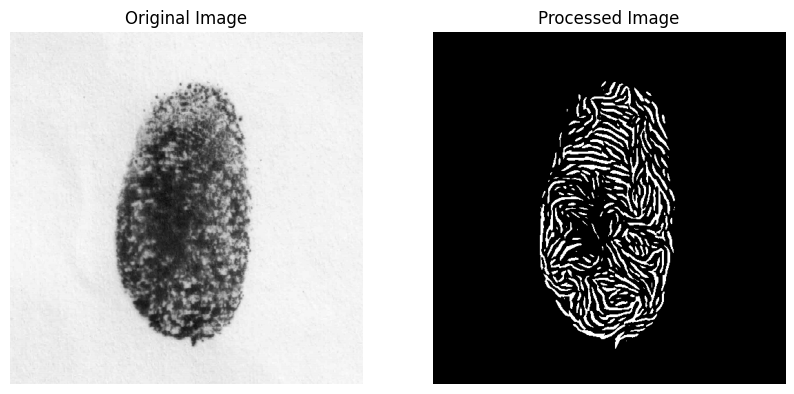

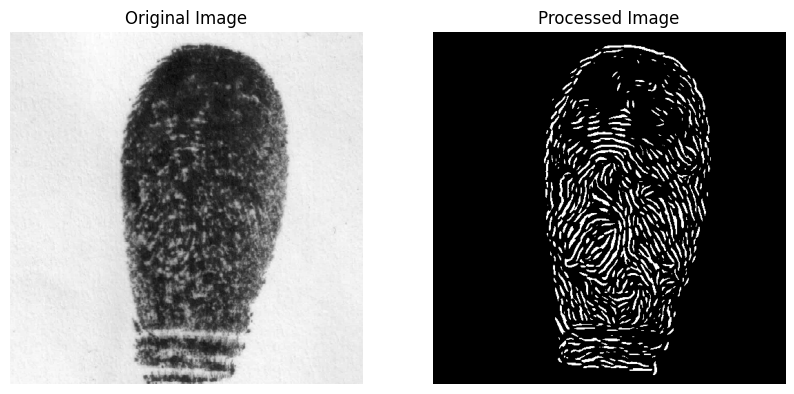

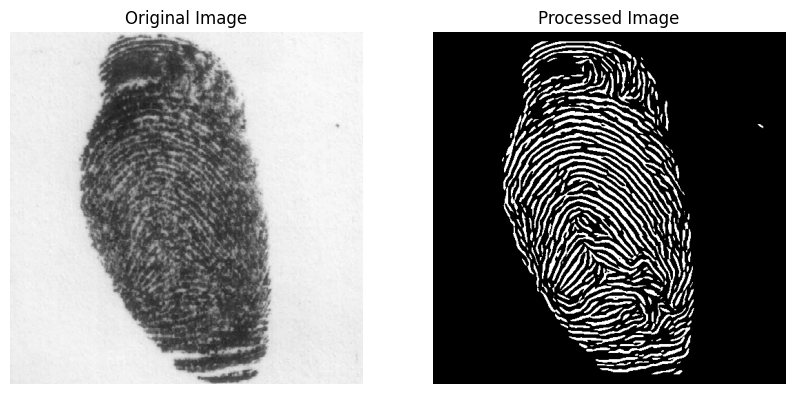

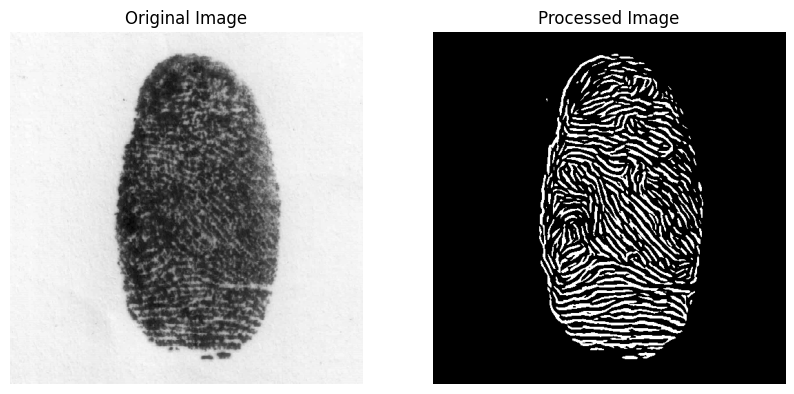

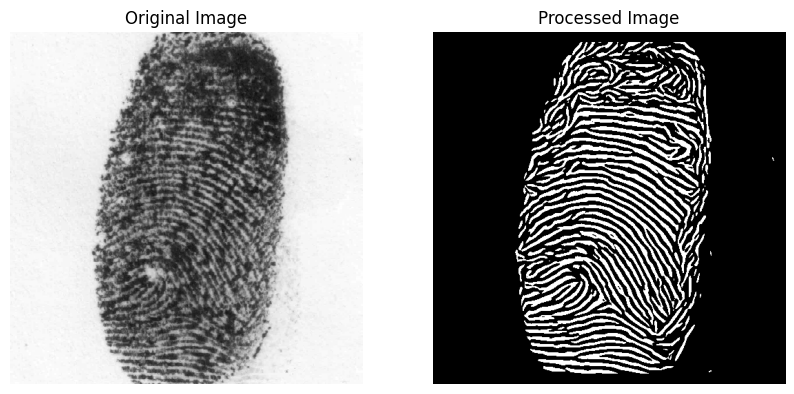

--------------------End Family 1 Father--------------------
--------------------Start Family 2 Father--------------------


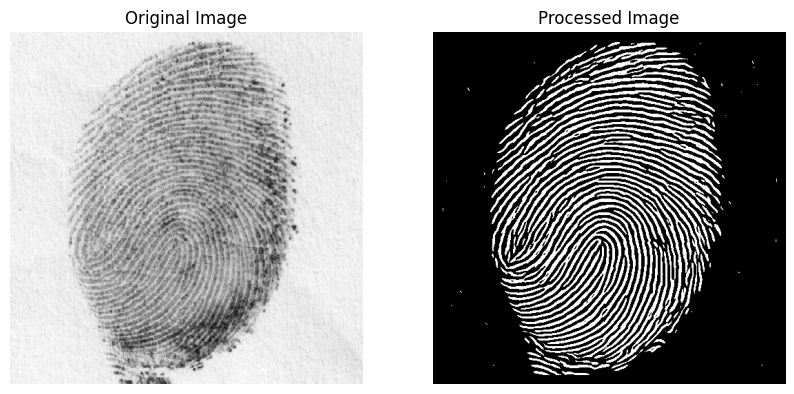

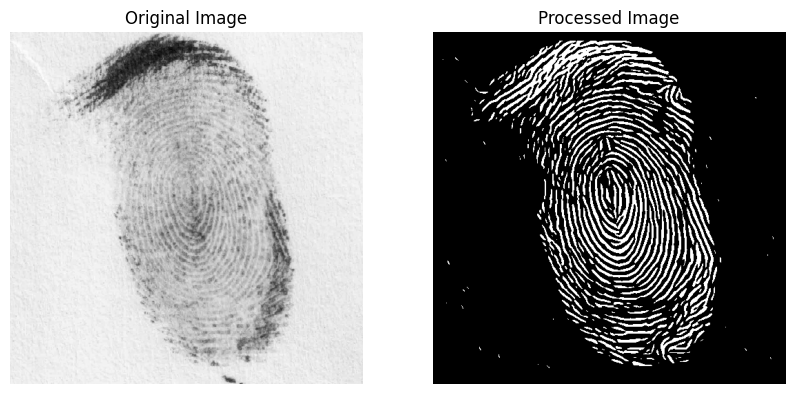

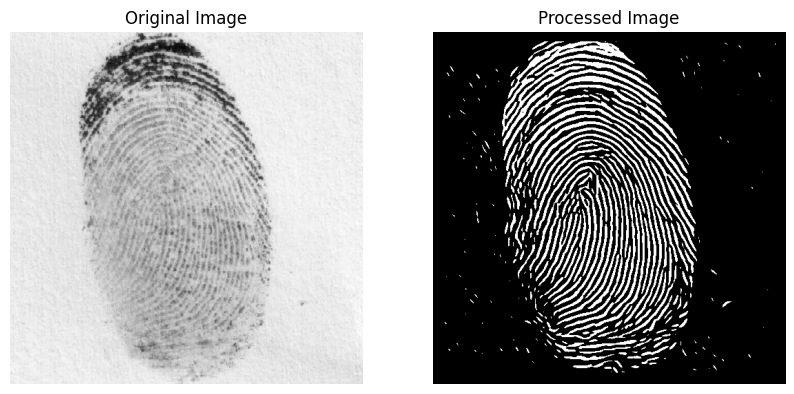

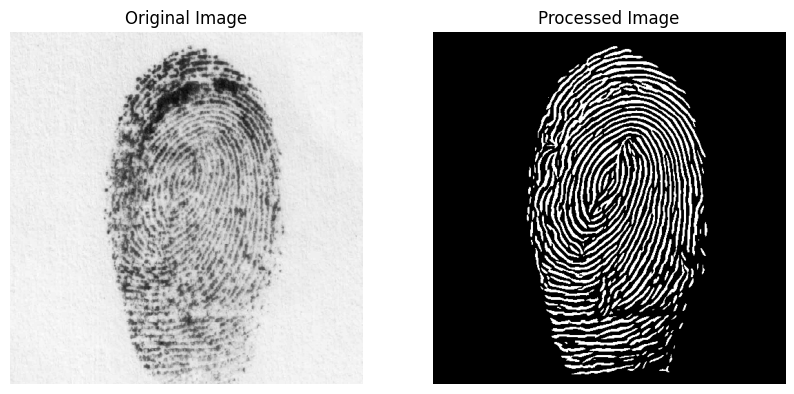

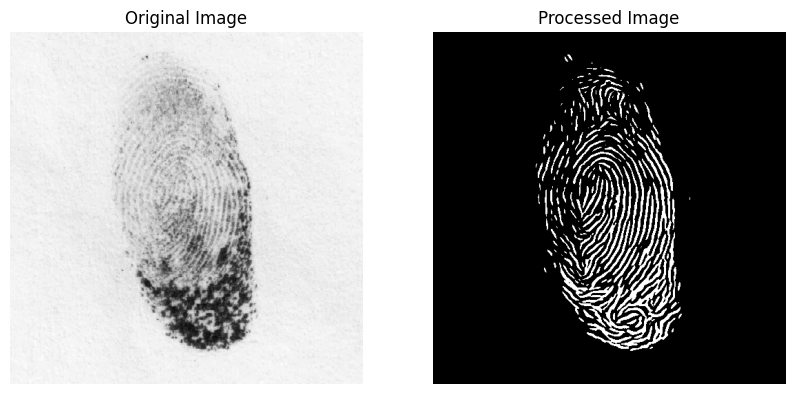

--------------------End Family 2 Father--------------------


In [10]:
# Father fingerprints
print('-'*20 + 'Start Family 1 Father' + '-'*20)
for i in range(1,6):
    image_name = FAMILY_1 + f'MOTHER/FM001_M{i}.png'
    image_enhancement(image_name)
print('-'*20 + 'End Family 1 Father' + '-'*20)

print('-'*20 + 'Start Family 2 Father' + '-'*20)
for i in range(1,6):
    image_name = FAMILY_2 + f'MOTHER/FM002_M{i}.png'
    image_enhancement(image_name)
print('-'*20 + 'End Family 2 Father' + '-'*20)

### SOCOFing (too small)

=> Choosing FVC2002

# LEVEL 1 FEATURE EXTRACTING

## Ridge Orientation and Frequency Estimation

In [8]:
from utils.ridge_segment import ridge_segment